# GameTheory 18b - Theoreme d'Existence de Nash (Python)

**Navigation** : [<< 4-NashEquilibrium (track principal)]([4-NashEquilibrium](GameTheory-4-NashEquilibrium.ipynb)) | [Index](README.md)

**Autres side tracks** : [4b-Lean-NashExistence](GameTheory-4b-Lean-NashExistence.ipynb)

**Companion Lean** : [GameTheory-4b-Lean-NashExistence](GameTheory-4b-Lean-NashExistence.ipynb)

**Kernel** : Python 3

---

## Introduction

Ce notebook Python accompagne le notebook Lean 18. Il fournit :

1. **Illustrations numeriques** du theoreme de Brouwer
2. **Algorithmes** de recherche de points fixes
3. **Exemples concrets** : Matching Pennies, meilleure reponse
4. **Lecture guidee** du depot math-xmum/Brouwer
5. **Contre-exemples** au theoreme de Brouwer

### Duree estimee : 30 minutes

## 1. Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, List

print("Configuration OK")
print(f"NumPy version: {np.__version__}")

Configuration OK
NumPy version: 2.4.1


## 2. Theoreme de Brouwer - Illustrations

### 2.1 Intuition geometrique

Le theoreme de Brouwer affirme que toute fonction continue $f: K \to K$ sur un compact convexe $K$ admet un point fixe.

**Intuition** : Imaginez une carte de France posee sur la France. Si vous deformez la carte continuellement, au moins un point reste au-dessus de sa position reelle.

In [2]:
def find_fixed_point_1d(f: Callable[[float], float], 
                        x0: float = 0.5, 
                        tol: float = 1e-6, 
                        max_iter: int = 100) -> Tuple[float, List[float]]:
    """
    Recherche d'un point fixe par iteration.
    
    Args:
        f: Fonction dont on cherche le point fixe
        x0: Point de depart
        tol: Tolerance de convergence
        max_iter: Nombre maximum d'iterations
    
    Returns:
        Point fixe approximatif et historique
    """
    x = x0
    history = [x]
    for _ in range(max_iter):
        x_new = f(x)
        history.append(x_new)
        if abs(x_new - x) < tol:
            return x_new, history
        x = x_new
    return x, history

# Exemple : f(x) = 0.5 * (x + 1/x) converge vers sqrt(1) = 1
f = lambda x: 0.5 * (x + 1/max(x, 0.01))
fixed, history = find_fixed_point_1d(f, x0=2.0)

print(f"Point fixe trouve: {fixed:.10f}")
print(f"Verification: f({fixed:.6f}) = {f(fixed):.10f}")
print(f"Iterations: {len(history)}")

Point fixe trouve: 1.0000000000
Verification: f(1.000000) = 1.0000000000
Iterations: 6


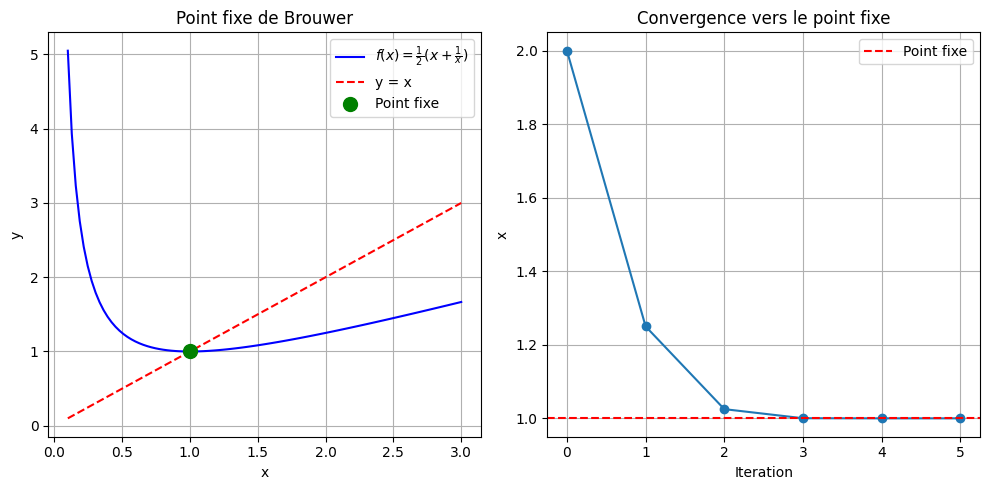

In [3]:
# Visualisation de la convergence
plt.figure(figsize=(10, 5))

# Graphique 1: Fonction et droite y=x
plt.subplot(1, 2, 1)
x = np.linspace(0.1, 3, 100)
y = [0.5 * (xi + 1/xi) for xi in x]
plt.plot(x, y, 'b-', label=r'$f(x) = \frac{1}{2}(x + \frac{1}{x})$')
plt.plot(x, x, 'r--', label='y = x')
plt.scatter([1], [1], color='green', s=100, zorder=5, label='Point fixe')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Point fixe de Brouwer')
plt.legend()
plt.grid(True)

# Graphique 2: Convergence
plt.subplot(1, 2, 2)
plt.plot(history, 'o-')
plt.axhline(y=1, color='r', linestyle='--', label='Point fixe')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Convergence vers le point fixe')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 2.2 Point fixe en 2D (sur le simplexe)

In [4]:
def find_fixed_point_simplex(f: Callable[[np.ndarray], np.ndarray],
                             x0: np.ndarray = None,
                             n: int = 2,
                             tol: float = 1e-6,
                             max_iter: int = 1000) -> Tuple[np.ndarray, List]:
    """
    Recherche de point fixe sur le simplexe standard.
    
    Le simplexe en dimension n-1 est:
    Delta = {x in R^n : x_i >= 0, sum(x) = 1}
    """
    if x0 is None:
        x0 = np.ones(n) / n  # Centre du simplexe
    
    x = x0.copy()
    history = [x.copy()]
    
    for _ in range(max_iter):
        x_new = f(x)
        # Projection sur le simplexe (clipping + normalisation)
        x_new = np.maximum(x_new, 0)
        x_new = x_new / x_new.sum()
        
        history.append(x_new.copy())
        
        if np.linalg.norm(x_new - x) < tol:
            return x_new, history
        x = x_new
    
    return x, history

# Exemple : rotation + contraction vers le centre
def example_map(x: np.ndarray) -> np.ndarray:
    """Fonction qui contracte vers (0.5, 0.5)"""
    center = np.array([0.5, 0.5])
    return 0.9 * x + 0.1 * center

fixed_2d, history_2d = find_fixed_point_simplex(example_map, x0=np.array([0.1, 0.9]))
print(f"Point fixe 2D: {fixed_2d}")
print(f"Somme: {fixed_2d.sum():.6f}")

Point fixe 2D: [0.49999373 0.50000627]
Somme: 1.000000


## 3. Application: Matching Pennies

Dans le jeu Matching Pennies :
- J1 veut que les pieces matchent (H,H) ou (T,T)
- J2 veut qu'elles different (H,T) ou (T,H)

In [5]:
# Matrices de gains
U1 = np.array([[1, -1], [-1, 1]])   # Joueur 1 (veut matcher)
U2 = np.array([[-1, 1], [1, -1]])   # Joueur 2 (veut mismatcher)

def expected_payoff(sigma1: np.ndarray, sigma2: np.ndarray, U: np.ndarray) -> float:
    """Calcule le gain espere."""
    return sigma1 @ U @ sigma2

def perturbed_br(sigma: np.ndarray, U: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
    """
    Calcule la meilleure reponse perturbee.
    
    Au lieu de sauter directement a la BR (qui cree des discontinuites),
    on ajoute du poids aux actions avec un regret positif.
    """
    # Gain actuel
    current = expected_payoff(sigma, sigma, U)
    
    # Regret pour chaque action pure
    regrets = np.zeros_like(sigma)
    for a in range(len(sigma)):
        pure_a = np.zeros_like(sigma)
        pure_a[a] = 1
        gain_a = expected_payoff(pure_a, sigma, U)
        regrets[a] = max(0, gain_a - current)
    
    # Perturbation
    perturbed = sigma + epsilon * regrets
    
    # Normaliser
    return perturbed / perturbed.sum()

# Test avec strategie uniforme
sigma_uniform = np.array([0.5, 0.5])

print("=" * 50)
print("MATCHING PENNIES - Point fixe")
print("=" * 50)
print(f"Strategie initiale: {sigma_uniform}")
print(f"Gain espere J1: {expected_payoff(sigma_uniform, sigma_uniform, U1):.4f}")
print(f"Gain espere J2: {expected_payoff(sigma_uniform, sigma_uniform, U2):.4f}")

# Verifier que (0.5, 0.5) est un point fixe
br_result = perturbed_br(sigma_uniform, U1)
print(f"\nMeilleure reponse perturbee: {br_result}")
print(f"Est un point fixe: {np.allclose(sigma_uniform, br_result)}")

MATCHING PENNIES - Point fixe
Strategie initiale: [0.5 0.5]
Gain espere J1: 0.0000
Gain espere J2: 0.0000

Meilleure reponse perturbee: [0.5 0.5]
Est un point fixe: True


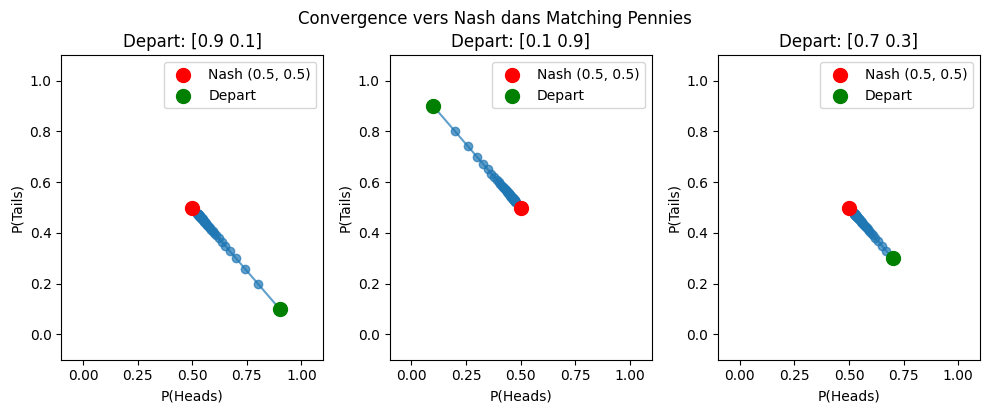

In [6]:
# Convergence depuis differents points de depart
starting_points = [
    np.array([0.9, 0.1]),
    np.array([0.1, 0.9]),
    np.array([0.7, 0.3]),
]

plt.figure(figsize=(10, 4))

for i, sigma0 in enumerate(starting_points):
    sigma = sigma0.copy()
    trajectory = [sigma.copy()]
    
    for _ in range(50):
        # Dynamique de meilleure reponse pour les deux joueurs
        sigma1_new = perturbed_br(sigma, U1, epsilon=0.2)
        sigma2_new = perturbed_br(sigma, U2, epsilon=0.2)
        # Moyenne (simplification)
        sigma = 0.5 * (sigma1_new + sigma2_new)
        trajectory.append(sigma.copy())
    
    trajectory = np.array(trajectory)
    plt.subplot(1, 3, i+1)
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'o-', alpha=0.7)
    plt.scatter([0.5], [0.5], color='red', s=100, zorder=5, label='Nash (0.5, 0.5)')
    plt.scatter([sigma0[0]], [sigma0[1]], color='green', s=100, zorder=5, label='Depart')
    plt.xlabel('P(Heads)')
    plt.ylabel('P(Tails)')
    plt.title(f'Depart: {sigma0}')
    plt.legend()
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.suptitle('Convergence vers Nash dans Matching Pennies', y=1.02)
plt.show()

## 4. Lecture Guidee : math-xmum/Brouwer

Le depot [math-xmum/Brouwer](https://github.com/math-xmum/Brouwer) contient une formalisation complete du theoreme d'existence de Nash en Lean 4.

### Structure du projet

In [7]:
print("="*70)
print("STRUCTURE DU DEPOT math-xmum/Brouwer")
print("="*70)
print("""
| Fichier              | Lignes | Contenu                              |
|----------------------|--------|--------------------------------------|
| Simplex.lean         | ~100   | Simplexe standard, distributions     |
| Scarf.lean           | ~3000  | Lemme de Scarf (colorages)           |
| Brouwer.lean         | ~1000  | Theoreme de Brouwer via Sperner      |
| Brouwer_product.lean | ~900   | Extension aux produits               |
| Nash.lean            | ~600   | Definition de jeu, existence Nash    |

Chaine de preuves:

    Lemme de Scarf (colorages de simplexes)
            |
            v
    Lemme de Sperner
            |
            v
    Theoreme de Brouwer (simplexe)
            |
            v
    Theoreme de Brouwer (produit de simplexes)
            |
            v
    Existence d'equilibre de Nash
""")

STRUCTURE DU DEPOT math-xmum/Brouwer

| Fichier              | Lignes | Contenu                              |
|----------------------|--------|--------------------------------------|
| Simplex.lean         | ~100   | Simplexe standard, distributions     |
| Scarf.lean           | ~3000  | Lemme de Scarf (colorages)           |
| Brouwer.lean         | ~1000  | Theoreme de Brouwer via Sperner      |
| Brouwer_product.lean | ~900   | Extension aux produits               |
| Nash.lean            | ~600   | Definition de jeu, existence Nash    |

Chaine de preuves:

    Lemme de Scarf (colorages de simplexes)
            |
            v
    Lemme de Sperner
            |
            v
    Theoreme de Brouwer (simplexe)
            |
            v
    Theoreme de Brouwer (produit de simplexes)
            |
            v
    Existence d'equilibre de Nash



In [8]:
print("="*70)
print("DEFINITIONS CLES (extraits de Nash.lean)")
print("="*70)
print("""
-- Structure de jeu
structure Game where
  I : Type*                          -- Ensemble des joueurs
  SS : I -> Type*                    -- Ensembles de strategies
  g : I -> (Pi i, SS i) -> R         -- Fonctions de gain

-- Le simplexe standard
def stdSimplex (alpha : Type*) : Type :=
  {f : alpha -> R // (forall x, 0 <= f x) and (sum x, f x = 1)}

-- Strategie mixte = distribution sur les actions
def MixedStrategy (g : Game) (i : g.I) := stdSimplex (g.SS i)

-- Equilibre de Nash
def IsNashEquilibrium (g : FiniteGame) (sigma : MixedProfile g) : Prop :=
  forall i, forall sigma'_i,
    ExpectedPayoff g i sigma >= ExpectedPayoff g i (deviate sigma i sigma'_i)
""")

DEFINITIONS CLES (extraits de Nash.lean)

-- Structure de jeu
structure Game where
  I : Type*                          -- Ensemble des joueurs
  SS : I -> Type*                    -- Ensembles de strategies
  g : I -> (Pi i, SS i) -> R         -- Fonctions de gain

-- Le simplexe standard
def stdSimplex (alpha : Type*) : Type :=
  {f : alpha -> R // (forall x, 0 <= f x) and (sum x, f x = 1)}

-- Strategie mixte = distribution sur les actions
def MixedStrategy (g : Game) (i : g.I) := stdSimplex (g.SS i)

-- Equilibre de Nash
def IsNashEquilibrium (g : FiniteGame) (sigma : MixedProfile g) : Prop :=
  forall i, forall sigma'_i,
    ExpectedPayoff g i sigma >= ExpectedPayoff g i (deviate sigma i sigma'_i)



In [9]:
print("="*70)
print("THEOREME DE BROUWER (extrait de Brouwer.lean)")
print("="*70)
print("""
-- Enonce simplifie du theoreme de Brouwer sur le simplexe

theorem brouwer_fixed_point 
    {n : N} 
    (f : stdSimplex (Fin n) -> stdSimplex (Fin n))
    (hf : Continuous f) :
    exists x, f x = x := by
  -- La preuve utilise le lemme de Sperner
  -- qui lui-meme utilise le lemme de Scarf
  -- sur les colorages de triangulations du simplexe
  sorry  -- Preuve complete dans le depot

-- La version sur produit de simplexes (pour Nash)

theorem brouwer_product_fixed_point
    {I : Type*} [Fintype I]
    {S : I -> Type*} [forall i, Fintype (S i)]
    (f : (Pi i, stdSimplex (S i)) -> (Pi i, stdSimplex (S i)))
    (hf : Continuous f) :
    exists x, f x = x := by
  -- Extension du theoreme de Brouwer au produit
  sorry
""")

THEOREME DE BROUWER (extrait de Brouwer.lean)

-- Enonce simplifie du theoreme de Brouwer sur le simplexe

theorem brouwer_fixed_point 
    {n : N} 
    (f : stdSimplex (Fin n) -> stdSimplex (Fin n))
    (hf : Continuous f) :
    exists x, f x = x := by
  -- La preuve utilise le lemme de Sperner
  -- qui lui-meme utilise le lemme de Scarf
  -- sur les colorages de triangulations du simplexe
  sorry  -- Preuve complete dans le depot

-- La version sur produit de simplexes (pour Nash)

theorem brouwer_product_fixed_point
    {I : Type*} [Fintype I]
    {S : I -> Type*} [forall i, Fintype (S i)]
    (f : (Pi i, stdSimplex (S i)) -> (Pi i, stdSimplex (S i)))
    (hf : Continuous f) :
    exists x, f x = x := by
  -- Extension du theoreme de Brouwer au produit
  sorry



## 5. Contre-exemples au Theoreme de Brouwer

Le theoreme de Brouwer requiert :
1. Un domaine **compact** (borne et ferme)
2. Un domaine **convexe**
3. Une fonction **continue**

Voyons ce qui se passe quand ces conditions ne sont pas satisfaites.

CONTRE-EXEMPLE 1: Domaine non compact

Sur R (non compact car non borne):

    f(x) = x + 1

Point fixe? f(x) = x  =>  x + 1 = x  =>  1 = 0  (contradiction)

Pas de point fixe car la fonction "fuit a l'infini".



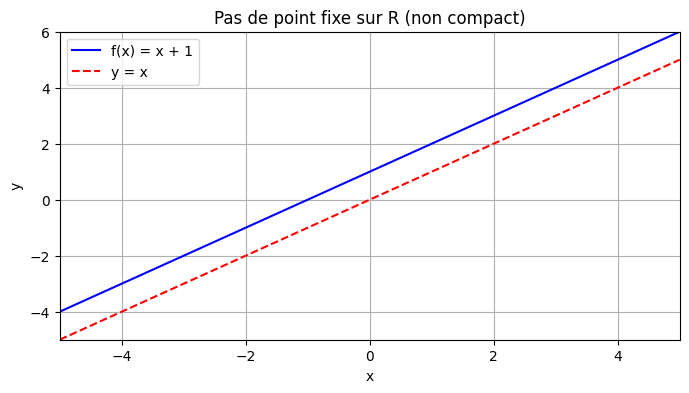

In [10]:
print("="*70)
print("CONTRE-EXEMPLE 1: Domaine non compact")
print("="*70)
print("""
Sur R (non compact car non borne):

    f(x) = x + 1

Point fixe? f(x) = x  =>  x + 1 = x  =>  1 = 0  (contradiction)

Pas de point fixe car la fonction "fuit a l'infini".
""")

# Illustration
x = np.linspace(-5, 5, 100)
plt.figure(figsize=(8, 4))
plt.plot(x, x + 1, 'b-', label='f(x) = x + 1')
plt.plot(x, x, 'r--', label='y = x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Pas de point fixe sur R (non compact)')
plt.legend()
plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-5, 6)
plt.show()

CONTRE-EXEMPLE 2: Fonction discontinue

Sur [0, 1] (compact et convexe), fonction discontinue:

    f(x) = 0.75  si x <= 0.5
         = 0.25  si x > 0.5

Point fixe?
- Si x <= 0.5 : f(x) = 0.75 = x  =>  x = 0.75 > 0.5 (contradiction)
- Si x > 0.5  : f(x) = 0.25 = x  =>  x = 0.25 <= 0.5 (contradiction)

Pas de point fixe car la fonction "saute" par-dessus la diagonale.



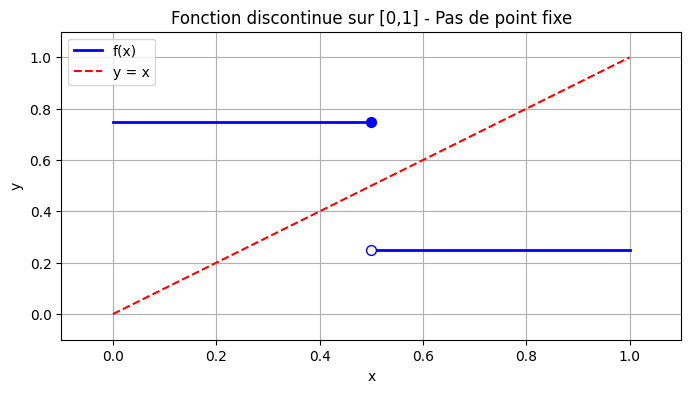

In [11]:
print("="*70)
print("CONTRE-EXEMPLE 2: Fonction discontinue")
print("="*70)
print("""
Sur [0, 1] (compact et convexe), fonction discontinue:

    f(x) = 0.75  si x <= 0.5
         = 0.25  si x > 0.5

Point fixe?
- Si x <= 0.5 : f(x) = 0.75 = x  =>  x = 0.75 > 0.5 (contradiction)
- Si x > 0.5  : f(x) = 0.25 = x  =>  x = 0.25 <= 0.5 (contradiction)

Pas de point fixe car la fonction "saute" par-dessus la diagonale.
""")

# Illustration
plt.figure(figsize=(8, 4))
x1 = np.linspace(0, 0.5, 50)
x2 = np.linspace(0.5, 1, 50)
plt.plot(x1, [0.75]*len(x1), 'b-', linewidth=2, label='f(x)')
plt.plot(x2, [0.25]*len(x2), 'b-', linewidth=2)
plt.scatter([0.5], [0.75], color='blue', s=50, zorder=5)  # Point ferme
plt.scatter([0.5], [0.25], color='white', edgecolor='blue', s=50, zorder=5)  # Point ouvert
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fonction discontinue sur [0,1] - Pas de point fixe')
plt.legend()
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

CONTRE-EXEMPLE 3: Domaine non convexe

Sur le cercle S^1 (compact mais non convexe):

    f(theta) = theta + pi  (mod 2*pi)

C'est une rotation de 180 degres.

Point fixe? f(theta) = theta  =>  theta + pi = theta  =>  pi = 0 (mod 2*pi)

Contradiction! Pas de point fixe car on peut "tourner sans jamais revenir".



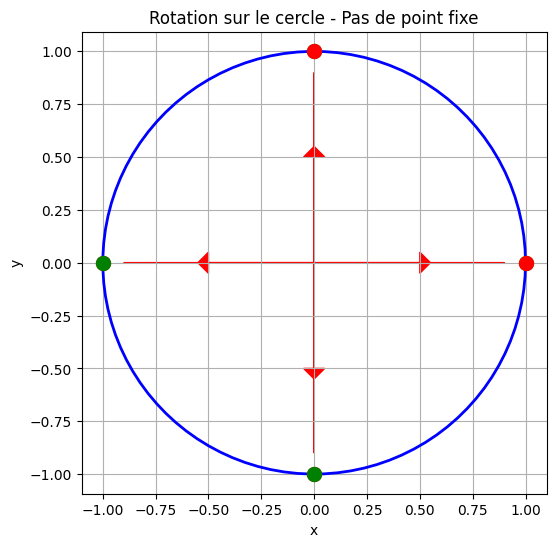

In [12]:
print("="*70)
print("CONTRE-EXEMPLE 3: Domaine non convexe")
print("="*70)
print("""
Sur le cercle S^1 (compact mais non convexe):

    f(theta) = theta + pi  (mod 2*pi)

C'est une rotation de 180 degres.

Point fixe? f(theta) = theta  =>  theta + pi = theta  =>  pi = 0 (mod 2*pi)

Contradiction! Pas de point fixe car on peut "tourner sans jamais revenir".
""")

# Illustration
theta = np.linspace(0, 2*np.pi, 100)
plt.figure(figsize=(6, 6))
plt.plot(np.cos(theta), np.sin(theta), 'b-', linewidth=2)

# Quelques points et leurs images
for t in [0, np.pi/2, np.pi, 3*np.pi/2]:
    x, y = np.cos(t), np.sin(t)
    x2, y2 = np.cos(t + np.pi), np.sin(t + np.pi)
    plt.arrow(x*0.9, y*0.9, (x2-x)*0.7, (y2-y)*0.7, 
              head_width=0.1, head_length=0.05, fc='red', ec='red')
    plt.scatter([x], [y], color='green', s=100, zorder=5)
    plt.scatter([x2], [y2], color='red', s=100, zorder=5)

plt.axis('equal')
plt.title('Rotation sur le cercle - Pas de point fixe')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

## 6. Resume

### Points cles

| Concept | Description |
|---------|-------------|
| **Brouwer** | Toute fonction continue $f: K \to K$ sur compact convexe a un point fixe |
| **Application Nash** | Un equilibre de Nash est un point fixe de la correspondance de meilleure reponse |
| **Condition compact** | Sans cette condition, la fonction peut "fuir a l'infini" |
| **Condition continue** | Sans cette condition, la fonction peut "sauter" par-dessus la diagonale |

### Ressources

- [math-xmum/Brouwer](https://github.com/math-xmum/Brouwer) - Formalisation complete en Lean 4
- [harfe/fixed-point-theorems-lean4](https://github.com/harfe/fixed-point-theorems-lean4) - Brouwer + Kakutani
- Nash, J. (1950). "Equilibrium Points in N-Person Games"

### Voir aussi

- Companion Lean : [GameTheory-18](GameTheory-4b-Lean-NashExistence.ipynb) pour les formalisations

---

**Navigation** : [← GameTheory-2b-Lean-Definitions](GameTheory-2b-Lean-Definitions.ipynb) | [Index](GameTheory-1-Setup.ipynb) | [GameTheory-8b-Lean-CombinatorialGames →](GameTheory-8b-Lean-CombinatorialGames.ipynb)